In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA

import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
telecome_data=pd.read_csv('telecom_churn_data.csv')

In [3]:
telecome_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
print(telecome_data['total_rech_amt_6'].isnull().sum(),telecome_data['total_rech_amt_7'].isnull().sum(), telecome_data['total_rech_data_6'].isnull().sum(), telecome_data['total_rech_data_7'].isnull().sum())

(0, 0, 74846, 74428)


In [5]:
#### Imputing missing values

telecome_data['total_rech_data_6'].fillna(0, inplace=True)
telecome_data['total_rech_data_7'].fillna(0, inplace=True)
telecome_data['total_rech_data_8'].fillna(0, inplace=True)
telecome_data['total_rech_data_9'].fillna(0, inplace=True)
telecome_data['av_rech_amt_data_6'].fillna(0, inplace=True)
telecome_data['av_rech_amt_data_7'].fillna(0, inplace=True)
telecome_data['av_rech_amt_data_8'].fillna(0, inplace=True)
telecome_data['av_rech_amt_data_9'].fillna(0, inplace=True)
telecome_data['max_rech_data_6'].fillna(0, inplace=True)
telecome_data['max_rech_data_7'].fillna(0, inplace=True)
telecome_data['max_rech_data_8'].fillna(0, inplace=True)
telecome_data['max_rech_data_9'].fillna(0, inplace=True)


telecome_data['night_pck_user_6'].fillna(-1, inplace=True)
telecome_data['night_pck_user_7'].fillna(-1, inplace=True)
telecome_data['night_pck_user_8'].fillna(-1, inplace=True)
telecome_data['night_pck_user_9'].fillna(-1, inplace=True)
telecome_data['fb_user_6'].fillna(-1, inplace=True)
telecome_data['fb_user_7'].fillna(-1, inplace=True)
telecome_data['fb_user_8'].fillna(-1, inplace=True)
telecome_data['fb_user_9'].fillna(-1, inplace=True)

In [6]:
#As per problem statement creating a column of average recharge amount of first two months
telecome_data['avg_rech_amt'] = ((telecome_data['total_rech_amt_6'] + telecome_data['total_rech_data_6']) + (telecome_data['total_rech_amt_7'] + telecome_data['total_rech_data_7']))/2

In [7]:
Q = telecome_data.avg_rech_amt.quantile(0.7)
telecome_data = telecome_data[telecome_data.avg_rech_amt >= Q]
telecome_data.shape

(30019, 227)

In [8]:
telecome_data['churn'] = np.where(((telecome_data['total_ic_mou_9']==0) & (telecome_data['total_og_mou_9']==0)) & ((telecome_data['vol_2g_mb_9']==0) & (telecome_data['vol_3g_mb_9']==0)),1,0)

In [9]:
telecome_data.shape

(30019, 228)

In [10]:
#dropping columns with '_9' at the end
new_col = [c for c in telecome_data.columns if c[-2:] != '_9']
telecome_data = telecome_data[new_col]

In [11]:
# # Checking percentage missing values in each columns
# round(100*(telecom.isnull().sum()/len(telecom.index)))
100*(telecome_data.isnull().sum()/len(telecome_data.index))

mobile_number            0.000000
circle_id                0.000000
loc_og_t2o_mou           0.379759
std_og_t2o_mou           0.379759
loc_ic_t2o_mou           0.379759
last_date_of_month_6     0.000000
last_date_of_month_7     0.103268
last_date_of_month_8     0.523002
arpu_6                   0.000000
arpu_7                   0.000000
arpu_8                   0.000000
onnet_mou_6              1.052667
onnet_mou_7              1.009361
onnet_mou_8              3.131350
offnet_mou_6             1.052667
offnet_mou_7             1.009361
offnet_mou_8             3.131350
roam_ic_mou_6            1.052667
roam_ic_mou_7            1.009361
roam_ic_mou_8            3.131350
roam_og_mou_6            1.052667
roam_og_mou_7            1.009361
roam_og_mou_8            3.131350
loc_og_t2t_mou_6         1.052667
loc_og_t2t_mou_7         1.009361
loc_og_t2t_mou_8         3.131350
loc_og_t2m_mou_6         1.052667
loc_og_t2m_mou_7         1.009361
loc_og_t2m_mou_8         3.131350
loc_og_t2f_mou

In [12]:
max(100*(telecome_data.isnull().sum()/len(telecome_data.index)))

61.87747759752157

In [13]:
#dropping columns which have more than 50% NaN values
for cl in telecome_data.columns:
    if round(100*(telecome_data[cl].isnull().sum()/len(telecome_data[cl].index)), 2) > 50:
        telecome_data = telecome_data.drop(cl, axis=1)

In [14]:
# Q = telecome_data.avg_rech_amt.quantile(0.7)

# telecome_data = telecome_data[telecome_data.avg_rech_amt >= Q]
telecome_data.shape

(30019, 174)

In [15]:
# All of the object datatype columns are of dates. We are dropping those here
obj_col =telecome_data.select_dtypes(include=['object']).columns

In [16]:
telecome_data = telecome_data.drop(obj_col,axis=1)
telecome_data = telecome_data.fillna(0)
# telecome_data.shape

In [17]:
telecome_data.shape

(30019, 165)

In [18]:
pd.set_option('display.max_rows', 500)
telecome_data.nunique().sort_values(ascending=True)


std_ic_t2o_mou_6          1
circle_id                 1
loc_og_t2o_mou            1
std_og_t2o_mou            1
loc_ic_t2o_mou            1
std_ic_t2o_mou_8          1
std_og_t2c_mou_8          1
std_og_t2c_mou_7          1
std_og_t2c_mou_6          1
std_ic_t2o_mou_7          1
churn                     2
night_pck_user_6          3
fb_user_6                 3
fb_user_7                 3
fb_user_8                 3
night_pck_user_7          3
night_pck_user_8          3
monthly_2g_6              5
monthly_2g_8              6
monthly_2g_7              6
monthly_3g_8             12
monthly_3g_6             12
monthly_3g_7             15
count_rech_3g_6          25
sachet_3g_6              25
sachet_3g_7              27
count_rech_3g_7          28
count_rech_3g_8          29
sachet_3g_8              29
sachet_2g_6              31
count_rech_2g_6          31
count_rech_2g_8          33
sachet_2g_7              34
sachet_2g_8              34
count_rech_2g_7          35
total_rech_data_6   

In [19]:
cat_list= ['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']
telecom_categorical= telecome_data[cat_list]
le = preprocessing.LabelEncoder()
telecom_categorical = telecom_categorical.apply(le.fit_transform)
telecom_categorical.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8
7,0,0,0,0,0,0
8,0,1,1,0,2,2
13,0,0,1,0,0,2
16,0,0,0,0,0,0
17,0,0,0,0,0,0


In [20]:
telecom_numerical = telecome_data.drop(cat_list, axis=1)

In [21]:
telecom_numerical = telecom_numerical.drop('churn', axis= 1)

In [22]:
telecom_numerical.nunique().sort_values(ascending=True)


circle_id                 1
loc_og_t2o_mou            1
std_og_t2o_mou            1
loc_ic_t2o_mou            1
std_ic_t2o_mou_8          1
std_ic_t2o_mou_7          1
std_ic_t2o_mou_6          1
std_og_t2c_mou_8          1
std_og_t2c_mou_7          1
std_og_t2c_mou_6          1
monthly_2g_6              5
monthly_2g_8              6
monthly_2g_7              6
monthly_3g_6             12
monthly_3g_8             12
monthly_3g_7             15
sachet_3g_6              25
count_rech_3g_6          25
sachet_3g_7              27
count_rech_3g_7          28
sachet_3g_8              29
count_rech_3g_8          29
count_rech_2g_6          31
sachet_2g_6              31
count_rech_2g_8          33
sachet_2g_8              34
sachet_2g_7              34
count_rech_2g_7          35
total_rech_data_6        38
total_rech_data_7        42
max_rech_data_6          44
total_rech_data_8        46
max_rech_data_7          47
max_rech_data_8          48
spl_ic_mou_6             78
spl_ic_mou_8        

In [23]:
#To capture maximum variance let's drop the columns which have less than or equal to 6 unique values
telecom_numerical = telecom_numerical.loc[:,telecome_data.apply(pd.Series.nunique) >6]

In [24]:
telecom_numerical.shape

(30019, 145)

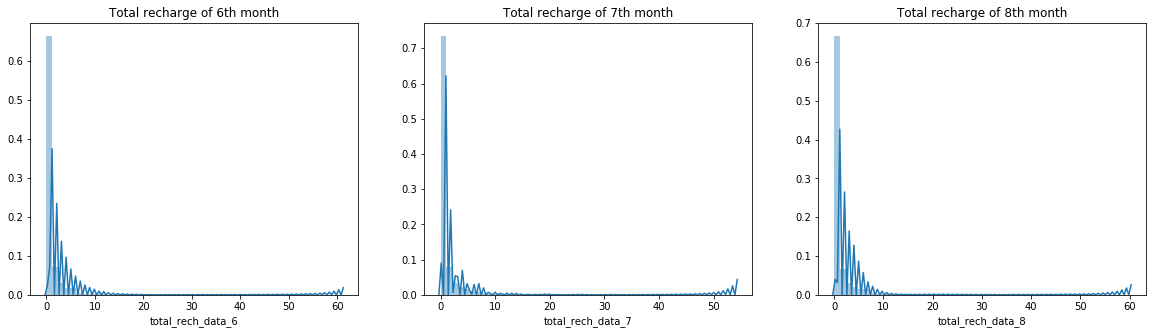

In [25]:
plt.figure(figsize=(20, 5))

# subplot 1
plt.subplot(131)
plt.title('Total recharge of 6th month')
sns.distplot(telecom_numerical['total_rech_data_6'])
# subplot 2 
plt.subplot(132)
plt.title('Total recharge of 7th month')
sns.distplot(telecom_numerical['total_rech_data_7'])


# subplot 3
plt.subplot(133)
plt.title('Total recharge of 8th month')
sns.distplot(telecom_numerical['total_rech_data_8'])


plt.show()

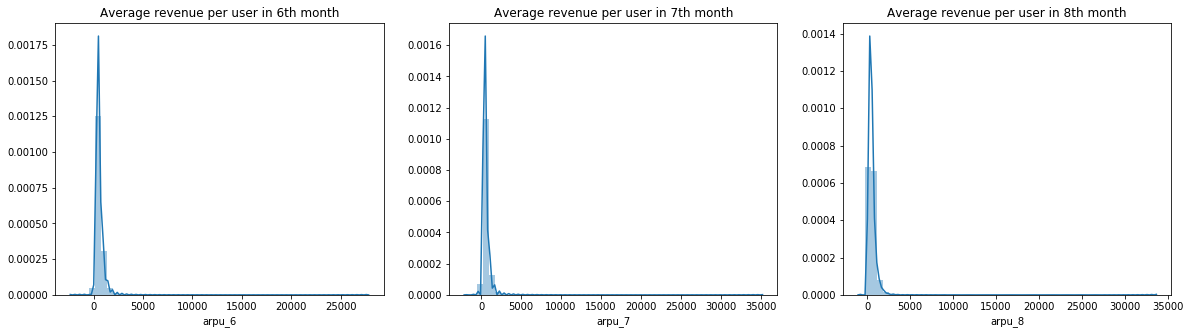

In [26]:
plt.figure(figsize=(20, 5))

# subplot 1
plt.subplot(131)
plt.title('Average revenue per user in 6th month')
sns.distplot(telecom_numerical['arpu_6'])
# subplot 2 
plt.subplot(132)
plt.title('Average revenue per user in 7th month')
sns.distplot(telecom_numerical['arpu_7'])


# subplot 3
plt.subplot(133)
plt.title('Average revenue per user in 8th month')
sns.distplot(telecom_numerical['arpu_8'])


plt.show()

In [27]:
main_frame = pd.concat([telecom_numerical,telecom_categorical, telecome_data['churn']], axis=1)


In [28]:
main_frame.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,jun_vbc_3g,sep_vbc_3g,avg_rech_amt,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,churn
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,18.74,0.0,1185.0,0,0,0,0,0,0,1
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,122.16,0.0,520.0,0,1,1,0,2,2,0
13,7002191713,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,...,0.00,0.0,380.0,0,0,1,0,0,2,0
16,7000875565,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,...,21.89,0.0,459.0,0,0,0,0,0,0,0
17,7000187447,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,0.00,5.54,...,0.00,0.0,408.0,0,0,0,0,0,0,0


In [29]:
X = main_frame.drop(['mobile_number','churn'], axis=1)
y = main_frame[['churn']]


In [30]:
X.shape,y.shape

((30019, 150), (30019, 1))

In [31]:
X = (X-X.mean())/X.std()

In [32]:
X


,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8
7,1.088734,1.643672,5.356653,-0.516541,-0.517829,-0.461133,0.075977,0.294928,-0.102440,-0.015047,...,-0.284286,-0.263855,-0.134764,0.997046,-0.769348,-0.784639,-0.789957,-0.769186,-0.782232,-0.778843
8,-0.471018,-0.209237,-0.807293,0.255787,0.097363,-0.498026,-0.686326,-0.705007,-0.499145,-0.220001,...,1.899631,0.001427,-0.134764,-0.363244,-0.769348,1.177056,1.174400,-0.769186,1.340322,1.379285
13,-0.213209,-0.828335,0.118884,0.446931,-0.406333,0.572028,-0.009268,-0.625572,0.225407,0.077137,...,-0.331773,-0.311925,-0.134764,-0.649621,-0.769348,-0.784639,1.174400,-0.769186,-0.782232,1.379285
16,-0.352976,-0.624819,-0.704635,-0.532450,-0.477702,-0.421860,-0.257909,-0.398551,-0.444109,-0.220001,...,-0.325770,-0.255775,-0.134764,-0.488023,-0.769348,-0.784639,-0.789957,-0.769186,-0.782232,-0.778843
17,0.232182,-1.231682,-1.034547,1.931793,-0.612075,-0.556528,-0.756486,-0.870721,-0.773360,-0.220001,...,-0.331773,-0.311925,-0.134764,-0.592346,-0.769348,-0.784639,-0.789957,-0.769186,-0.782232,-0.778843
21,-0.164398,0.018761,0.209288,-0.419807,-0.357092,-0.390712,0.722969,0.972170,1.274456,-0.220001,...,-0.331773,-0.311925,-0.134764,-0.117778,-0.769348,-0.784639,-0.789957,-0.769186,-0.782232,-0.778843
24,-0.373137,-0.495489,-0.365572,-0.372537,-0.516770,-0.270729,0.069390,-0.109296,-0.191548,-0.102560,...,-0.331773,-0.311925,-0.134764,-0.639393,-0.769348,-0.784639,-0.789957,-0.769186,-0.782232,-0.778843
33,0.880544,3.832228,-0.254981,-0.642075,-0.631339,-0.573227,-0.887457,-0.870721,-0.784961,-0.220001,...,6.300887,4.086372,-0.134764,2.538367,3.159049,3.138750,1.174400,1.357472,1.340322,1.379285
38,-0.504302,-0.221476,-0.286106,-0.101674,0.655633,0.855297,-0.698650,-0.766767,-0.580128,-0.220001,...,-0.331773,-0.311925,-0.134764,-0.346880,-0.769348,-0.784639,-0.789957,-0.769186,-0.782232,-0.778843
41,-0.235830,-0.352822,-0.619564,-0.454577,-0.384556,-0.400787,-0.393745,-0.293651,-0.498705,-0.220001,...,-0.331773,-0.311925,-0.134764,-0.398018,-0.769348,-0.784639,-0.789957,-0.769186,-0.782232,-0.778843


In [33]:
X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.7,test_size=0.3,random_state=100)

In [34]:
# Percentage of churned customers(instances) in traing dataset
y_train[y_train['churn']==1].count()/y_train['churn'].count() * 100

churn    8.523295
dtype: float64

In [35]:
y_test[y_test['churn']==1].count()/y_test['churn'].count() * 100

churn    8.871863
dtype: float64

In [36]:
#Creating an instance of PCA
pca1 = PCA(svd_solver='randomized', random_state=100)

In [37]:
pca1.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
  svd_solver='randomized', tol=0.0, whiten=False)

In [38]:
pca1.components_

array([[ 6.31865254e-02,  6.65973674e-02,  6.76840394e-02, ...,
         1.51400082e-01,  1.53428164e-01,  1.49152490e-01],
       [ 1.65722174e-01,  1.85794553e-01,  1.82551704e-01, ...,
        -3.89326129e-02, -3.78458656e-02, -2.26306334e-02],
       [ 1.12799685e-01,  1.40402867e-01,  1.22136795e-01, ...,
        -1.23558148e-02, -6.08426758e-03, -1.45152014e-03],
       ...,
       [ 0.00000000e+00,  3.33941095e-16, -9.61336373e-17, ...,
         2.70081881e-17, -1.95843972e-16,  2.01789524e-16],
       [ 0.00000000e+00,  6.01102758e-17, -1.52840869e-16, ...,
         9.41566395e-17, -8.07545031e-17,  6.55494583e-17],
       [-0.00000000e+00,  5.03441000e-16,  3.25010223e-17, ...,
        -2.28021343e-16, -1.81639481e-17,  9.41270985e-18]])

In [39]:
# colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca1.components_[0],'PC2':pca1.components_[1], 'Feature':X_train.columns})
pcs_df.head()

,Feature,PC1,PC2
0,arpu_6,0.063187,0.165722
1,arpu_7,0.066597,0.185795
2,arpu_8,0.067684,0.182552
3,onnet_mou_6,-0.042046,0.075509
4,onnet_mou_7,-0.043906,0.086259


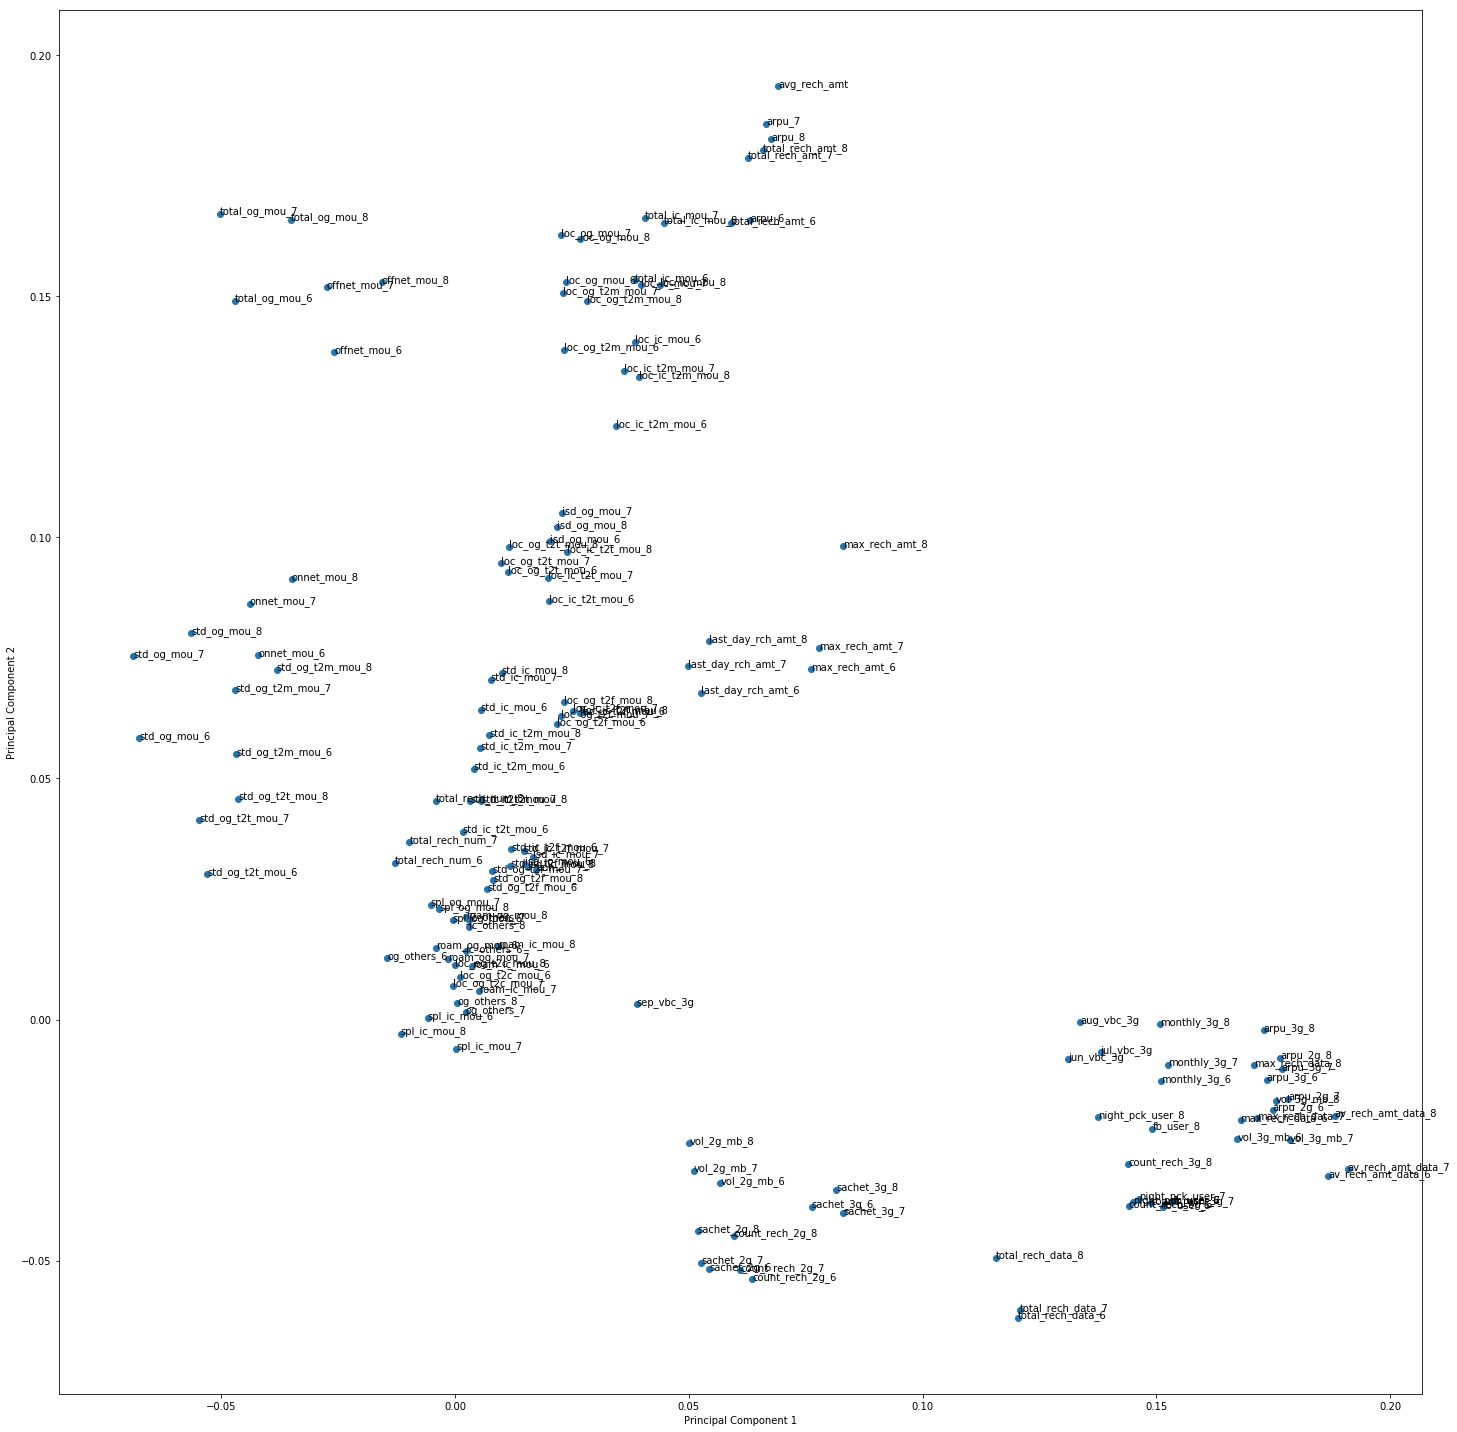

In [40]:
fig = plt.figure(figsize = (20,20))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

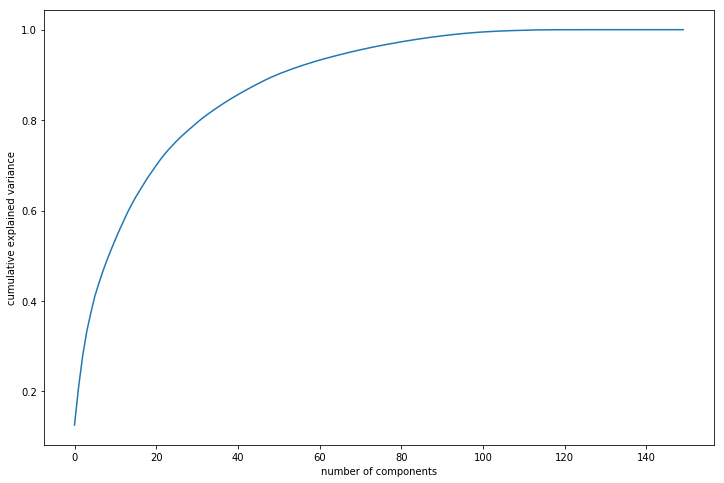

In [41]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [42]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=35)

In [43]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(21013, 35)

In [44]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

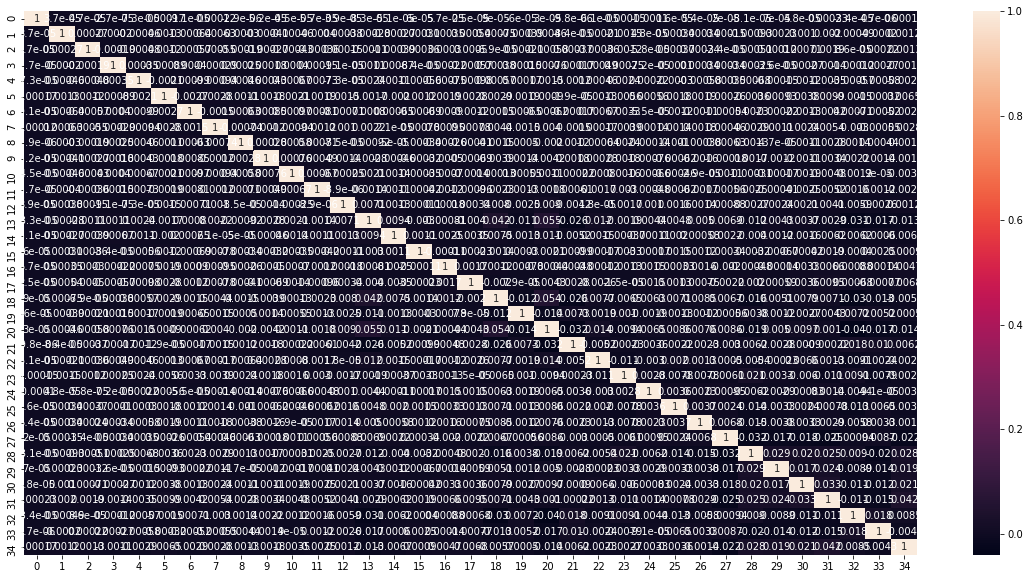

In [45]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [46]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

('max corr:', 0.054583142122925934, ', min corr: ', -0.040015504090379336)


In [47]:
#Applying selected components to the test data - 16 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(9006, 35)

In [48]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [49]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.87'

In [50]:
# y_train.churn.map({0:'green',1:'red'})
len(y_train[y_train.churn==1])

1791

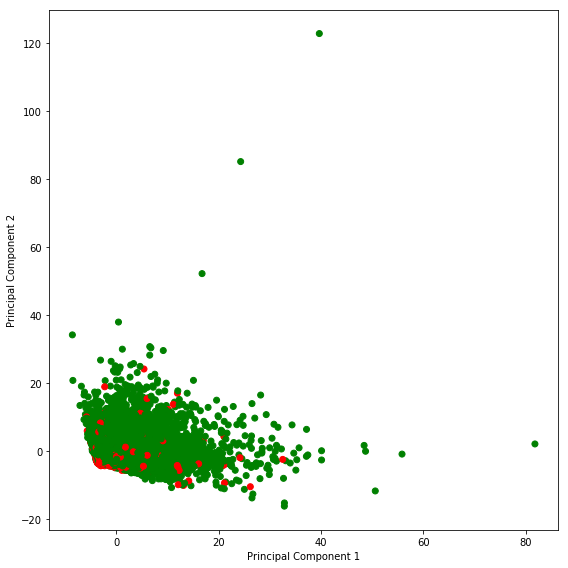

In [51]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.churn.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [52]:
pca_again = PCA(0.99)

In [53]:
df_train_pca2 = pca_again.fit_transform(X_train)
df_train_pca2.shape
# we see that PCA selected 14 components

(21013, 95)

In [54]:
df_test_pca2 = pca_again.transform(X_test)
df_test_pca2.shape

(9006, 95)

In [55]:
#training the regression model
learner_pca2 = LogisticRegression(C=10,)
model_pca2 = learner_pca2.fit(df_train_pca2,y_train)

In [56]:
#Making prediction on the test data
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test2))


'0.89'

In [57]:
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=[0 if i < 0.5 else 1  for i in pred_probs_test2 ])


array([[8103,  104],
       [ 581,  218]])

In [58]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the cross-
 |  entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle
 |  both dense and sparse input. Use C-ordered arrays or CSR matrices
 |  containing 64-bit floats for optimal performance; any other input format
 |  will be converted (and copied).
 |  
 |  The 'newton-cg', 'sag', and 'lbfgs' solve

In [59]:
from sklearn.svm import SVC
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# instantiating a model with cost=1
model = SVC(C = 1)


In [60]:
# fit
model.fit(df_train_pca2, y_train)

# predict
y_pred = model.predict(df_test_pca2)
# df_test_pca2[0]


In [61]:
# # y_pred,y_test
# test=list(y_test.churn)
# count=0
# right_prediction=0
# wrong_rediction=0
# for index,data in enumerate(y_pred):
#     print test[index],data
#     if test[index]==1:
#         count+=1
#         if(test[index]==data):
#             right_prediction+=1
#         else:
#             wrong_rediction+=1
            
# count,right_prediction,wrong_rediction
    




In [62]:
# Evaluate the model using confusion matrix 
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[8098,  109],
       [ 563,  236]])

In [63]:
print("accuracy", metrics.accuracy_score(y_test, y_pred))

('accuracy', 0.9253830779480346)


In [64]:
##Random Forest

In [79]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

# specify number of folds for k-fold CV
n_folds = 5


# parameters to build the model on
parameters = {'max_depth': range(2, 40, 5)}

rf = GridSearchCV(rfc, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
# instantiate the model
# rf = RandomForestClassifier()




In [80]:
rf.fit(X_train, y_train)

# predict
y_pred = model.predict(df_test_pca2)
# df_test_pca2[0]

In [81]:
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[8098,  109],
       [ 563,  236]])

In [82]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.169321,0.003411,0.940370,0.940929,2,{u'max_depth': 2},4,0.937203,0.940092,0.940995,...,0.940267,0.943192,0.939077,0.941229,0.944312,0.939147,0.006669,0.000063,0.002351,0.001348
1,0.494688,0.004777,0.941274,0.948223,7,{u'max_depth': 7},1,0.939581,0.949432,0.941232,...,0.938839,0.947951,0.940029,0.947237,0.946692,0.948665,0.003551,0.000136,0.002818,0.000756
2,0.778739,0.006523,0.941227,0.973148,12,{u'max_depth': 12},2,0.938154,0.972515,0.942422,...,0.941456,0.972221,0.936459,0.973589,0.947644,0.971566,0.007296,0.000463,0.003869,0.001500
3,0.976405,0.007784,0.940846,0.988864,17,{u'max_depth': 17},3,0.940533,0.988697,0.942898,...,0.938839,0.988519,0.937649,0.990482,0.944312,0.987330,0.014800,0.000451,0.002473,0.001030
4,1.096147,0.008383,0.939656,0.993016,22,{u'max_depth': 22},5,0.939106,0.992266,0.940519,...,0.938363,0.993338,0.935745,0.993576,0.944550,0.992624,0.068702,0.000808,0.002897,0.000490
